**Case3 : Crosswell experiment: Ellipsoidal velocity anomaly with a single point source**

In [ ]:
!pip install SALib

In [ ]:
import pickle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
import time
from SALib.sample import sobol_sequence
import scipy.interpolate as interpolate

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [ ]:
tf.reset_default_graph()

In [ ]:
x = tf.placeholder(tf.float64, shape=(None, 1))
z = tf.placeholder(tf.float64, shape=(None,1))
t = tf.placeholder(tf.float64, shape=(None,1))

nx = nz = 100  # number of nodes along x-axis and z-axis. used here to remove the specfem's absorbing regions from PINN's computational domain
n_abs = 10     # number of nodes for absorbing B.C. in both directions from specfem
n_absx = n_abs # nodes from left side of the domain = 10
n_absz = n_abs # the top boundary is not absorbing = 10

ax_spec = 1.5 # domain size in specfem before removing absorbing regions, x-length of domain
az_spec = 0.5 # z-length of domain
xsf = 1.3 # x location of all the seismometers in specfem

dx=ax_spec/nx # dx = 0.015
dz=az_spec/nz # dz = 0.005
rho = 1.0
ax = xsf - n_absx*dx # dimension of the domain in the x direction for PINNs training. Note = 1.15
#we just need to remove the thickness of the absorbing B.C on the left since
#xsf is (must be) smaller than where the right side absorbing B.C starts
az=az_spec-n_absz*dz#dimension of the domain in the z direction  = 0.45
t_m=0.5#total time for PDE training.
t_st=0.1#this is when we take the first I.C from specfem
t_s=0.5#total time series used from the seismograms

s_spec=5e-5#specfem time stepsize
t01 = 2000*s_spec # initial disp. input at this time
t02=2300*s_spec#sec "initial" disp. input at this time from spec instead of enforcing initial velocity
t_la=5000*s_spec# test data for comparing specfem and trained PINNs
n_event=1# number of seismic events
n_seis=20#number of input seismometers from SPECFEM; if events have different
#numbers of seismometers, you have to change the lines containing n_seis accordingly
z0_s = az# z location of the first seismometer from SPECFEM in PINN's refrence frame.Here it must = = 0.45
# be in km while in SPECFEM it's in meters. Note here we assume seismometers are
# NOT all on the surface and they are on a vertical line with the same x; the first
#seismometers is at the surface and the next one goes deeper

zl_s=0.06-n_absz*dz# z location of the last seismometer at depth. this doesn't have = 0.009999999999999995
#to be zero and can be higher especially if you have absorbing B.C at the bottom, change
#this accordingly based on what you used from specfem

Lx=3;#this is for scaling the wavespeed in the PDE via saling x coordinate
Lz=3;#this is for scaling the wavespeed in the PDE via scaling z coordinate


#Here we define the true ground velocity
def g(x,z,a,b,c,d):
  return ((x-c)**2/a**2 + (z-d)**2/b**2)

alpha_true = 3 - 0.25*(1 + tf.tanh(100 * (1 - g(x*Lx, z*Lz, 0.18, 0.1, 1.0-n_absx*dx, 0.3-n_absz*dz))))

In [ ]:
print( g(x*Lx, z*Lz, 0.18, 0.1, 1.0-n_absx*dx, 0.3-n_absz*dz))

Tensor("add_2:0", shape=(?, 1), dtype=float64)


In [ ]:
ub=np.array([ax/Lx,az/Lz,(t_m-t_st)]).reshape(-1,1).T# normalization of the input to the NN
print(ub)
ub0=np.array([ax/Lx,az/Lz]).reshape(-1,1).T#same for the inverse NN estimating the wave_speed
print(ub0)

[[0.38333333 0.15       0.4       ]]
[[0.38333333 0.15      ]]


In [ ]:
def xavier_init(size):
    in_dim = size[0]
    out_dim = size[1]
    xavier_stddev = np.sqrt(2.0/(in_dim + out_dim))
    return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev,dtype=tf.float64), dtype=tf.float64)

def neural_net(X, weights, biases):   # [x,y,t]
  num_layers = len(weights) + 1
  H = 2*(X/ub)-1  # normalization map to [-1, 1]
  for l in range(0, num_layers-2):
    W = weights[l]
    b = biases[l]
    H = tf.nn.tanh(tf.add(tf.matmul(H,W),b))
  W = weights[-1]
  b = biases[-1]
  Y = tf.add(tf.matmul(H,W),b)
  return Y

def neural_net0(X, weights, biases):  # [x,y]
  num_layers = len(weights) + 1
  H=2*(X/ub0)-1
  for l in range(0,num_layers-2):
      W = weights[l]
      b = biases[l]
      H = tf.nn.tanh(tf.add(tf.matmul(H, W), b))


  W = weights[-1]
  b = biases[-1]
  Y = tf.add(tf.matmul(H, W), b)
  return Y

In [ ]:
layers = [3] + [30]*3 + [1] # layers for the first NN to approximate the displacement field
print('Layers from first NN :',layers)
L = len(layers)
weights = [xavier_init([layers[l], layers[l+1]]) for l in range(0, L-1)]
biases = [tf.Variable( tf.zeros((1, layers[l+1]),dtype=tf.float64)) for l in range(0, L-1)]
num_epoch = 10000001


layers0=[2]+[20]*5+[1] # layers for the second NN to approximate the wavespeed
print('Layers from second NN : ',layers0)
L0 = len(layers0)
weights0 = [xavier_init([layers0[l], layers0[l+1]]) for l in range(0, L0-1)]
biases0 = [tf.Variable( tf.zeros((1, layers0[l+1]),dtype=tf.float64)) for l in range(0, L0-1)]

learning_rate = 1.e-4

alpha_star = tf.tanh(neural_net0(tf.concat((x,z),axis=1), weights0, biases0))

Layers from first NN : [3, 30, 30, 30, 1]
Layers from second NN :  [2, 20, 20, 20, 20, 20, 1]


In [ ]:
# Choose the box within which you are doing the inversion
z_st = 0.1 - n_absz*dz # #We are removing the absorbing layer from z_st to make it with reference to PINN's coordinate
z_fi=0.45-n_absz*dz
x_st=0.7-n_absx*dx
x_fi=1.25-n_absx*dx
print(z_st, z_fi, x_st, x_fi)
lld = 1000
alpha_bound = 0.5*(1+tf.tanh(lld*(z-z_st/Lz))) * 0.5*(1+tf.tanh(lld*(-z+z_fi/Lz))) * 0.5*(1+tf.tanh(lld*(x-x_st/Lx))) * 0.5*(1+tf.tanh(lld*(-x+x_fi/Lx)))#confining the inversion to a box and not the whole region
alpha = 3 + 2*alpha_star*alpha_bound
print(alpha)

0.05 0.4 0.5499999999999999 1.1
Tensor("add_15:0", shape=(?, 1), dtype=float64)


In [ ]:
#### Scalar acoustic wave potential
phi = neural_net(tf.concat((x,z,t),axis=1), weights, biases)
P = (1/Lx)**2 * tf.gradients(tf.gradients(phi,x)[0], x)[0] + (1/Lz)**2*tf.gradients(tf.gradients(phi,z)[0],z)[0]
eq = tf.gradients(tf.gradients(phi,t)[0],t)[0] - alpha**2 * P

ux= tf.gradients(phi,x)[0] #u=grad(phi)
uz= tf.gradients(phi,z)[0]
Vel_x=tf.gradients(ux,t)[0]#velocity field
Vel_z=tf.gradients(uz,t)[0]

### PDE residuals
batch_size=40
n_pde=batch_size*2
print('batch_size',':',batch_size, 'n_pde points : ', n_pde)

X_pde = sobol_sequence.sample(n_pde+1, 3)[1:,:]
print(X_pde)

In [ ]:
X_pde[:,0] = X_pde[:,0] * ax/Lx
X_pde[:,1] = X_pde[:,1] * az/Lz
X_pde[:,2] = X_pde[:,2] * (t_m-t_st)
print(X_pde)

In [ ]:
###initial conditions for all events
# coordinates on which the wavefield output is recorded on specfem. It's the same for all the runs with the same meshing system in specfem

X0 = np.loadtxt('wavefield_grid_for_dumps_000.txt')
X0=X0/1000#specfem works with meters unit so we need to convert them to Km
X0[:, 0:1] = X0[:,0:1]/Lx  #scaling the spatial domain
X0[:,1:2]=X0[:,1:2]/Lz#scaling the spatial domain
xz=np.concatenate((X0[:,0:1],X0[:,1:2]),axis=1)

n_ini = 40
xx, zz =  np.meshgrid(np.linspace(0,ax/Lx,n_ini),np.linspace(0,az/Lz,n_ini))
xxzz = np.concatenate((xx.reshape((-1,1)), zz.reshape((-1,1))),axis=1)
#for enforcing the disp I.C
X_init1 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),0.0*np.ones((n_ini**2,1),dtype=np.float64)),axis=1)
#for enforcing the sec I.C, another snapshot of specfem
X_init2 = np.concatenate((xx.reshape((-1,1)),zz.reshape((-1,1)),(t02-t01)*np.ones((n_ini**2,1),dtype=np.float64)),axis=1)

#interpolationg specfem results in the non-absrobing part of the domain only
xf = n_absx*dx  #start of the nonabsorbing part of the domain in specfem = 0.15
zf=n_absz*dz    # 0.05
xxs, zzs = np.meshgrid(np.linspace(xf/Lx,xsf/Lx,n_ini),np.linspace(zf/Lz,az_spec/Lz,n_ini))
xxzzs = np.concatenate((xxs.reshape((-1,1)), zzs.reshape((-1,1))),axis=1)

u_scl=1/3640 #scaling the output data to cover [-1 1] interval

In [ ]:
U0 = np.loadtxt('wavefield0002000_01_000.txt')
U1 = np.loadtxt('wavefield0002300_01_000.txt')
U2 = np.loadtxt('wavefield0005000_01_000.txt')

U_ini1 = interpolate.griddata(xz, U0, xxzzs, fill_value=0.0)
U_ini1x=U_ini1[:,0:1]
U_ini1z=U_ini1[:,1:2]


U_ini2 = interpolate.griddata(xz, U1, xxzzs, fill_value=0.0)
U_ini2x=U_ini2[:,0:1]/u_scl
U_ini2z=U_ini2[:,1:2]/u_scl

U_spec = interpolate.griddata(xz, U2, xxzzs, fill_value=0.0)#Test data
U_specx=U_spec[:,0:1]
U_specz=U_spec[:,1:2]


In [ ]:
min(U_ini1x)

array([-0.00025503])

In [ ]:
min(U_ini2x)

array([-0.81846434])

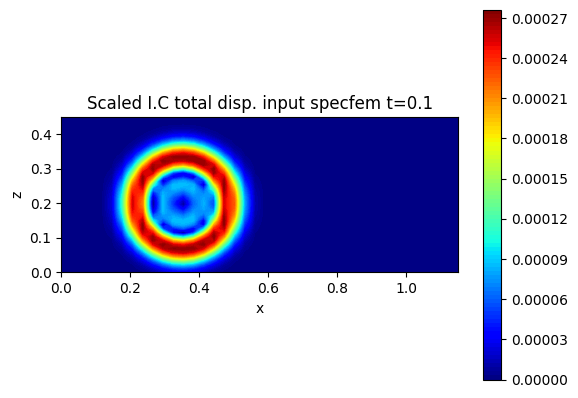

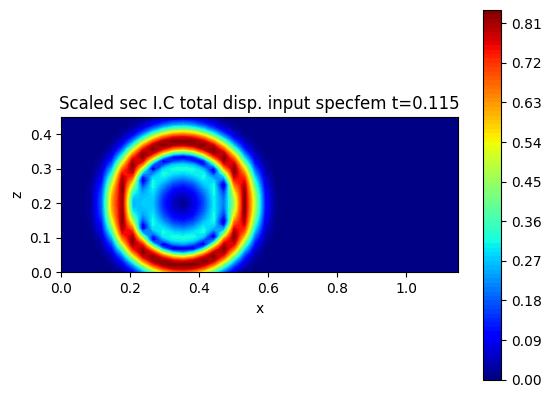

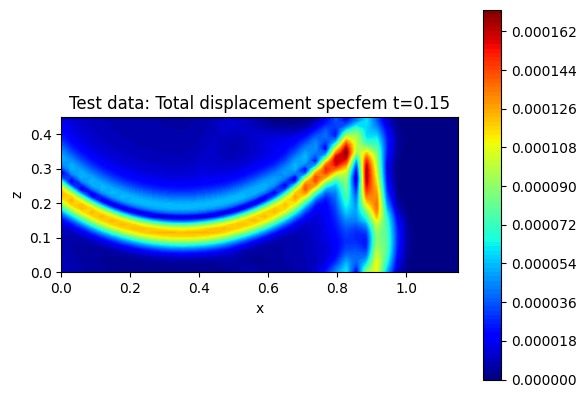

In [ ]:
################### plots of inputs for sum of the events
fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini1x**2+U_ini1z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled I.C total disp. input specfem t='+str(t01))
plt.colorbar()
plt.axis('scaled')
plt.savefig('Ini_total_disp_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)



fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_ini2x**2+U_ini2z**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Scaled sec I.C total disp. input specfem t='+str(round(t02, 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('sec_wavefield_input_spec_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)



fig = plt.figure()
plt.contourf(xx*Lx, zz*Lz, np.sqrt(U_specx**2+U_specz**2).reshape(xx.shape),100, cmap='jet')
plt.xlabel('x')
plt.ylabel('z')
plt.title('Test data: Total displacement specfem t='+str(round((t_la-t01), 4)))
plt.colorbar()
plt.axis('scaled')
plt.savefig('total_disp_spec_testData_sumEvents.png', dpi=400)
plt.show()
plt.close(fig)
###############################################################